In [11]:
pip install moviepy

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [12]:
from pydub import AudioSegment

# Load the .mp3 file
mp3_audio = AudioSegment.from_mp3("/kaggle/input/dataset-clips-audio/clip_subset/common_voice_hi_41228332.mp3")

# Export as .wav file
#mp3_audio.export("output_file_41228332.wav", format="wav")

In [13]:
from IPython.display import Audio

# Load and play the .wav file
audio_file = "output_file_41228332.wav"
Audio(audio_file)


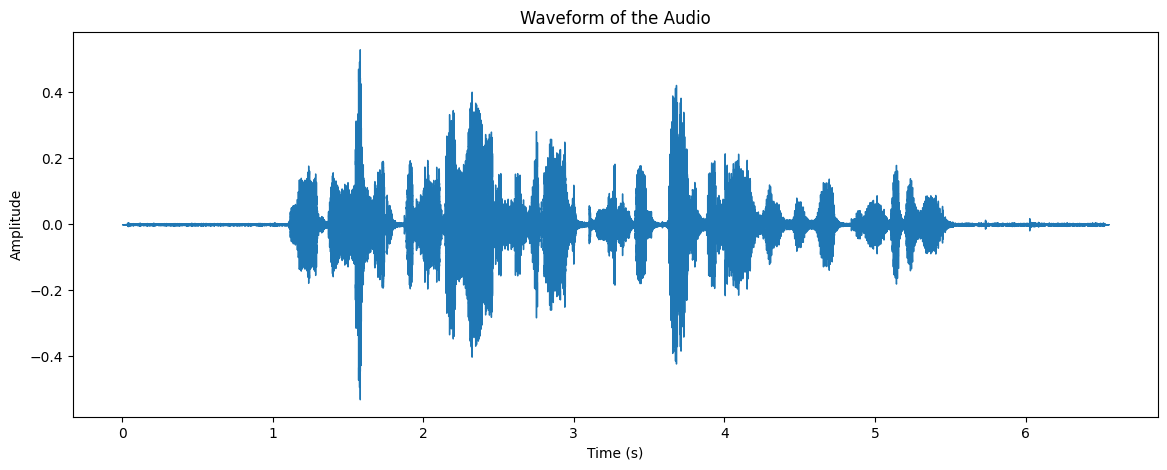

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the .wav file
audio_path = "output_file_41228332.wav"
y, sr = librosa.load(audio_path, sr=None)  # sr=None preserves the original sample rate

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


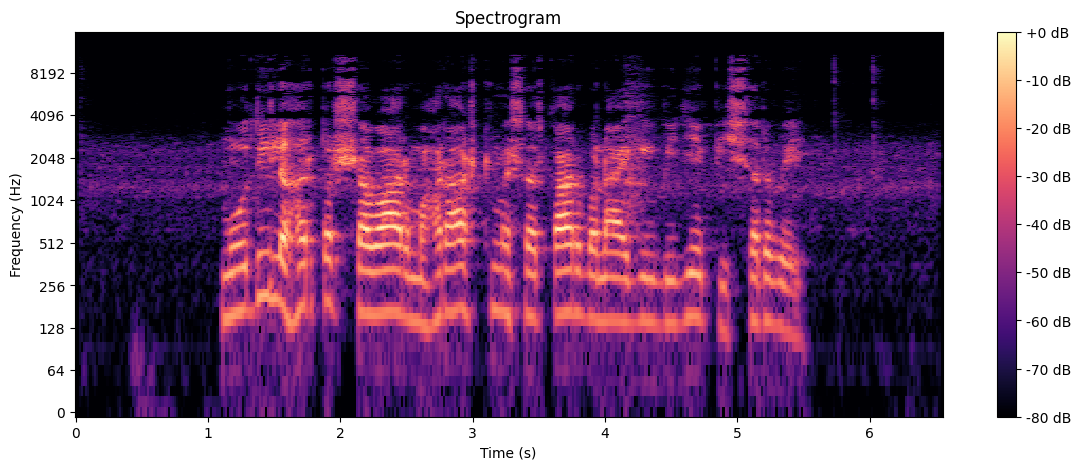

In [15]:
import numpy as np
import librosa.display

# Generate a spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [16]:
#pip install transformers datasets librosa torchaudio


In [17]:
#!pip install fairseq torchaudio

In [18]:
#!wget https://dl.fbaipublicfiles.com/fairseq/wav2vec/wav2vec_large.pt

In [22]:
import torch
import torchaudio
from fairseq import checkpoint_utils

# Load the pretrained Wav2Vec 2.0 model
model_path = "wav2vec_large.pt"
model, cfg, task = checkpoint_utils.load_model_ensemble_and_task([model_path])

# Set the model to evaluation mode
model[0].eval()


Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2-4): 3 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (5-6): 2 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU

In [24]:
# Load your .wav file
wav_path = "output_file_41228332.wav"  # Replace with your audio file path
waveform, sample_rate = torchaudio.load(wav_path)

# Resample the audio to 16kHz if it's not already
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

# Ensure the waveform is of shape [1, num_samples]
if waveform.ndim == 1:
    waveform = waveform.unsqueeze(0)


In [26]:
# Move model to CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model[0].to(device)

# Move waveform to the same device
waveform = waveform.to(device)

# Forward pass through the model
with torch.no_grad():
    outputs = model[0](waveform)

# Inspect the output dictionary
print(outputs)


{'cpc_logits': tensor([[ -0.3606,  -7.8235, -16.5108,  ..., -18.8203, -23.0187, -29.6044],
        [ -2.8738, -12.4928, -22.3384,  ..., -18.4335,  -9.1285, -16.6843],
        [  1.1629, -16.0900,  -7.8033,  ..., -20.2792, -20.5718,  -6.9429],
        ...,
        [ -1.7801,  -2.2911,  -1.8497,  ...,  -2.3039,  -7.5059,  -0.8485],
        [ -1.2172,  -8.0210,  -8.9557,  ..., -10.3432,  -6.6117, -10.3895],
        [ -1.4072,  -7.8411,  -6.8173,  ...,  -7.8655,  -6.1662,  -1.1954]]), 'cpc_targets': tensor([0, 0, 0,  ..., 0, 0, 0])}


In [27]:
# Move model to CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model[0].to(device)

# Move waveform to the same device
waveform = waveform.to(device)

# Forward pass through the model
with torch.no_grad():
    outputs = model[0](waveform)

# Access the logits
logits = outputs['cpc_logits']  # Access the correct key

# Convert logits to predicted tokens (CTC decoding)
predicted_tokens = torch.argmax(logits, dim=-1)

# Map tokens to characters using the task’s target dictionary
transcription = task.target_dictionary.string(predicted_tokens[0])

print("Transcribed Text:", transcription)


AttributeError: 'NoneType' object has no attribute 'string'